In [1]:
"""
计算势场格点数据
计算当前设置的势场对应的静电势、赝势和总势场（单位为V）的格点数据
"""

import numpy as np
import math
import json
import argparse
from scipy.constants import e
from scipy.signal import savgol_filter
import csv
import traceback
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 从 monolithic.py 导入必要的类和函数（使用条件导入避免执行全局代码）
import sys
import os

# 添加路径以便导入
# 在notebook中，使用当前工作目录
import os
current_dir = os.getcwd()
if 'src' in current_dir:
    sys.path.insert(0, current_dir)
else:
    # 如果不在src目录，尝试添加src目录
    src_dir = os.path.join(current_dir, 'src')
    if os.path.exists(src_dir):
        sys.path.insert(0, src_dir)

# 导入必要的函数和类（避免执行 monolithic.py 的全局代码）
from utils import *

# 定义必要的常量和函数（从 monolithic.py 复制）
flag_smoothing = True
default_filename = "../../data/monolithic20241118.csv"
default_basis_filename = "./electrode_basis_7.json"

def smoothing(data):
    """由于电势场数据崎岖不平，因而做的平滑化函数"""
    return savgol_filter(data, 11, 3)

def loadConfig(fileName):
    """工具函数：加载JSON配置"""
    try:
        with open(fileName, 'r', encoding='utf-8') as jf:
            config = json.load(jf)
        return config
    except Exception as e:
        print(traceback.format_exc())
        return -1

def interpret_voltage(value):
    """工具函数：解释电压值"""
    if type(value) == list:
        return value[0]
    return value

def R2(x, y):
    """
    计算R²（决定系数）
    x: fit data
    y: raw data
    """
    return 1 - np.sum((x-y)**2)/np.sum((y-np.mean(y))**2)

In [2]:
# 定义 Data_Loader 类（从 monolithic.py 复制）
class Data_Loader:
    def __init__(self, filename=default_filename):
        self.filename = filename
        self.data = []
        self.keymaps = {}
        self.keynames = []
        self.basis = {}
        self.unit_l = 1e-3
        self.basisGroup_map = {}
        self.units = {"m": 1e0, "cm": 1e-2, "mm": 1e-3, "um": 1e-6}
        self.smoothing = smoothing
        self.grids_dc = None
        self.grids_rf = None
    
    def getcol(self, key):
        """把电势场名key转换为表格的列序号"""
        if key in self.keymaps:
            return self.keymaps[key]
        else:
            cols = [v for k, v in self.keymaps.items() if (key == k.split(".")[0])]
            return cols[0] if len(cols) > 0 else None
    
    def loadData(self, name=None, dV=None, dl=None):
        """读取加载电势场格点文件数据"""
        try:
            self.load_Settings_CustomBasis()
            print("加载自定义Basis设置")
        except Exception as er:
            print(er)
        if name is None:
            name = self.filename
        with open(name, encoding='utf-8', mode='r') as file_read:
            csvread = csv.reader(file_read)
            for i, row in enumerate(csvread):
                if i > 20:
                    break
                if row[0] == r'% Length unit':
                    self.unit_l = self.units[row[1]]
                    print("self.unit_l=", self.unit_l)
                if row[0] == r'% x':
                    self.keymaps = {row[v].replace(r"% ", ""): v for v in range(len(row))}
                    self.keynames = [name for name in self.keymaps if name not in ["x", "y", "z"]]
                    break
        dat = pd.read_csv(name, comment='%', header=None)
        data = dat.to_numpy()
        
        # 如果提供了 dV 和 dl，进行单位转换
        if dV is not None and dl is not None:
            data[:, 3:] *= 1/dV  # csv文件内的电势单位：V -> 归一化单位
            data[:, 0:3] *= self.unit_l/dl  # csv文件内坐标的长度单位：mm -> 归一化单位
        
        data = data[np.lexsort([data[:, 2], data[:, 1], data[:, 0]])]
        self.coordinate = [self.x, self.y, self.z] = [x, y, z] = [np.unique(data[:, i]) for i in range(3)]
        self.data = data
    
    def load_basis(self, key):
        """加载电势场名key的格点数据"""
        coln = self.getcol(key)
        
        if coln is None:
            components = self.basisGroup_map[key]
            outputs = self.load_basis(components)
        else:
            outputs = self.data[:, coln].reshape(len(self.x), len(self.y), len(self.z))
        
        if flag_smoothing and self.smoothing is not None:
            outputs = self.smoothing(outputs)
        return outputs
    
    def load_Settings_CustomBasis(self):
        """加载自定义Basis设置"""
        self.basisGroup_map = loadConfig(default_basis_filename)
    
    def set_coordinate_um(self, dl):
        """设置坐标（单位：um）"""
        self.coordinate_um = [temp/(1e-6/dl) for temp in self.coordinate]

# 定义 load_electrode_config 函数（从 monolithic.py 复制）
def oscillate_RF(t):
    """RF场的时间函数。单位时间为dt"""
    return np.cos(2*t)

TIME_FUNCTION_MAP = {
    "oscillate_RF": oscillate_RF,
}

def load_electrode_config(config_path):
    """从配置文件加载电极电压配置"""
    default_Vrf = 550/2
    default_freq_RF = 35.28
    default_V_static = {"RF": -8, "U1": 0, "U2": 0, "U3": 0, "U4": -1, "U5": 0, "U6": 0, "U7": 0}
    
    try:
        config = loadConfig(config_path)
        if config == -1:
            print(f"警告: 无法加载配置文件 {config_path}，使用默认配置")
            return default_V_static, {"RF": [default_Vrf, oscillate_RF]}, default_Vrf, default_freq_RF
        
        rf_settings = config.get("rf_settings", {})
        Vrf = rf_settings.get("Vrf", default_Vrf)
        freq_RF = rf_settings.get("freq_RF", default_freq_RF)
        
        electrode_config = config.get("electrode_voltages", {})
        V_static = electrode_config.get("static", default_V_static)
        
        dynamic_config = electrode_config.get("dynamic", {})
        V_dynamic = {}
        time_functions_config = config.get("time_functions", {})
        
        for key, value in dynamic_config.items():
            if isinstance(value, dict):
                voltage = value.get("voltage", 0)
                func_name = value.get("time_function", "")
                
                if func_name in time_functions_config:
                    func_config = time_functions_config[func_name]
                    if func_name in TIME_FUNCTION_MAP:
                        time_func = TIME_FUNCTION_MAP[func_name]
                    else:
                        time_func = lambda t: 1.0
                elif func_name in TIME_FUNCTION_MAP:
                    time_func = TIME_FUNCTION_MAP[func_name]
                else:
                    print(f"警告: 未找到时间函数 {func_name}，使用默认函数")
                    time_func = lambda t: 1.0
                
                V_dynamic[key] = [voltage, time_func]
            else:
                V_dynamic[key] = value
        
        print(f"成功加载配置文件: {config_path}")
        return V_static, V_dynamic, Vrf, freq_RF
        
    except Exception as e:
        print(f"加载配置文件时出错: {e}")
        print("使用默认配置")
        return default_V_static, {"RF": [default_Vrf, oscillate_RF]}, default_Vrf, default_freq_RF

In [6]:
def calculate_potential_fields(config_path='./config.json', 
                               data_filename=None, 
                               basis_filename_local=None):
    """
    计算静电势、赝势和总势场的格点数据
    
    参数:
        config_path: 配置文件路径
        data_filename: 电势场格点数据文件路径（如果为None，使用默认值）
        basis_filename_local: Basis设置文件路径（如果为None，使用默认值）
    
    返回:
        dict: 包含以下键的字典
            - 'coordinates': dict, 包含 'x', 'y', 'z' 坐标数组（单位：um）
            - 'coordinates_normalized': dict, 包含归一化坐标数组
            - 'V_static': numpy.ndarray, 静电势格点数据（单位：V）
            - 'V_pseudo': numpy.ndarray, 赝势格点数据（单位：V）
            - 'V_total': numpy.ndarray, 总势场格点数据（单位：V）
            - 'dV': float, 单位电压
            - 'dl': float, 单位长度
            - 'dt': float, 单位时间
    """
    # 临时设置全局 basis_filename（用于 Data_Loader）
    global default_basis_filename

    # 使用提供的文件名或默认值
    if data_filename is None:
        data_filename = default_filename
    if basis_filename_local is None:
        basis_filename_local = default_basis_filename

    old_basis = default_basis_filename
    default_basis_filename = basis_filename_local
    
    print(f"使用数据文件: {data_filename}")
    print(f"使用Basis文件: {basis_filename_local}")
    
    # 加载电极配置
    V_static, V_dynamic, Vrf, freq_RF = load_electrode_config(config_path)
    
    # 计算物理常数
    pi = math.pi
    Omega = freq_RF * 2 * pi * 10**6  # RF射频角频率@SI
    epsl = 8.854*10**(-12)  # 真空介电常数@SI
    m = 2.239367e-25  # Ba135 离子的质量 @SI
    ec = e  # 元电荷@SI
    
    dt = 2/Omega  # 单位时间dt
    dl = ((ec**2)/(4*pi*m*epsl*(Omega)**2))**(1/3)  # 单位长度dl
    dV = m/ec*(dl/dt)**2  # 单位电压dV
    
    print(f'dt={dt}, dl={dl}, dV={dV}')
    
    # 加载数据（传入 dV 和 dl 进行单位转换）
    data_loader = Data_Loader(data_filename)
    data_loader.loadData(dV=dV, dl=dl)
    
    # 设置坐标（单位：um）
    data_loader.set_coordinate_um(dl)
    
    # 计算静电势（归一化单位）
    potential_static = 0
    for key, value in V_static.items():
        potential_static = potential_static + data_loader.load_basis(key) * interpret_voltage(value)
    
    # 转换为国际单位制（V）
    V_static_SI = potential_static * dV
    
    # 计算赝势
    def pseudo_potential():
        """计算赝势（单位：V）"""
        V0 = data_loader.load_basis("RF") * interpret_voltage(Vrf) * ec * dV  # 此处统一使用国际单位制
        [x, y, z] = data_loader.coordinate_um  # 换算成国际单位制
        Fx, Fy, Fz = np.gradient(-V0, x, y, z, edge_order=2)
        F0 = np.sqrt(Fx**2 + Fy**2 + Fz**2) * 1e6  # 因为距离单位为um，所以梯度要乘1e6
        V_pseudo_rf = F0**2/(4*m*Omega**2*ec)
        return V_pseudo_rf
    
    V_pseudo_SI = pseudo_potential()
    
    # 计算总势场
    V_total_SI = V_static_SI + V_pseudo_SI
    
    # 恢复全局变量
    default_basis_filename = old_basis
    
    # 获取坐标（单位：um）
    coordinates_um = {
        'x': data_loader.coordinate_um[0],
        'y': data_loader.coordinate_um[1],
        'z': data_loader.coordinate_um[2]
    }
    
    # 获取归一化坐标
    coordinates_normalized = {
        'x': data_loader.coordinate[0],
        'y': data_loader.coordinate[1],
        'z': data_loader.coordinate[2]
    }
    
    # 返回结果
    result = {
        'coordinates': coordinates_um,
        'coordinates_normalized': coordinates_normalized,
        'V_static': V_static_SI,
        'V_pseudo': V_pseudo_SI,
        'V_total': V_total_SI,
        'dV': dV,
        'dl': dl,
        'dt': dt,
        'shape': V_static_SI.shape,
        'Vrf': Vrf,
        'freq_RF': freq_RF
    }
    
    print(f"势场计算完成")
    print(f"格点形状: {result['shape']}")
    print(f"静电势范围: [{np.min(V_static_SI):.4f}, {np.max(V_static_SI):.4f}] V")
    print(f"赝势范围: [{np.min(V_pseudo_SI):.4f}, {np.max(V_pseudo_SI):.4f}] V")
    print(f"总势场范围: [{np.min(V_total_SI):.4f}, {np.max(V_total_SI):.4f}] V")
    
    return result

# 计算势场数据
config_path = './config.json'
result = calculate_potential_fields(config_path=config_path)

使用数据文件: ../../data/monolithic20241118.csv
使用Basis文件: ./electrode_basis_7.json
成功加载配置文件: ./config.json
dt=9.022389064166401e-09, dl=2.757463340646677e-07, dV=0.0013055432790611363
加载自定义Basis设置
self.unit_l= 0.001
势场计算完成
格点形状: (101, 51, 201)
静电势范围: [-7.0036, -6.1186] V
赝势范围: [0.0000, 1.1023] V
总势场范围: [-6.3554, -5.5924] V


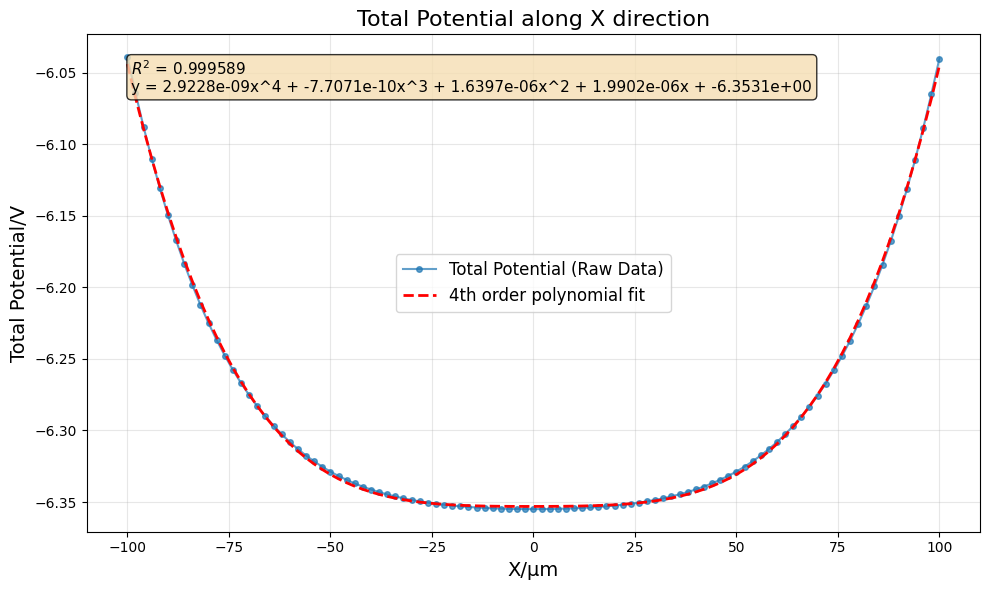


拟合结果 - Total Potential 沿 X 方向
拟合阶数: 4
R² (决定系数): 0.99958874

拟合系数 (从高次到低次):
  x^4 项系数: 2.922769e-09
  x^3 项系数: -7.707093e-10
  x^2 项系数: 1.639744e-06
  x 项系数: 1.990207e-06
  常数项: -6.353096e+00

拟合方程: y = 2.9228e-09x^4 + -7.7071e-10x^3 + 1.6397e-06x^2 + 1.9902e-06x + -6.3531e+00

数据范围:
  坐标范围: [-100.00, 100.00] μm
  势场范围: [-6.3550, -6.0389] V


In [8]:
# 绘制势场分布并拟合
# 可配置参数
direction = 'x'  # 选择方向: 'x', 'y', 或 'z'
field_type = 'V_total'  # 选择势场类型: 'V_static', 'V_pseudo', 或 'V_total'
fit_order = 4  # 拟合阶数: 2 (二次) 或 4 (四次)

# 方向映射
direction_map = {'x': 0, 'y': 1, 'z': 2}
direction_labels = {'x': 'X', 'y': 'Y', 'z': 'Z'}
field_labels = {
    'V_static': 'Static Potential',
    'V_pseudo': 'Pseudo Potential',
    'V_total': 'Total Potential'
}

# 获取数据
ax_id = direction_map[direction]
shape = result['shape']
V_field = result[field_type]
coords_um = result['coordinates'][direction]

# 提取中心切面的数据
Vs_0 = np.take(np.take(V_field, 
                       [int(np.ceil(shape[(ax_id+1)%3]/2))], 
                        axis=(ax_id+1)%3), 
               [int(np.ceil(shape[(ax_id+2)%3]/2))], 
               axis=(ax_id+2)%3).flatten()

# 进行多项式拟合
coeffs = np.polyfit(coords_um, Vs_0, fit_order)
V_fit = np.polyval(coeffs, coords_um)

# 计算R²
r2 = R2(V_fit, Vs_0)

# 绘制图形
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(coords_um, Vs_0, 'o-', label=f'{field_labels[field_type]} (Raw Data)', 
        markersize=4, linewidth=1.5, alpha=0.7)
ax.plot(coords_um, V_fit, '--', label=f'{fit_order}th order polynomial fit', 
        linewidth=2, color='red')

ax.set_xlabel(f'{direction_labels[direction]}/μm', fontsize=14)
ax.set_ylabel(f'{field_labels[field_type]}/V', fontsize=14)
ax.set_title(f'{field_labels[field_type]} along {direction_labels[direction]} direction', fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# 在图上显示拟合结果
fit_equation = f"y = "
for i, coeff in enumerate(coeffs):
    power = fit_order - i
    if power == 0:
        fit_equation += f"{coeff:.4e}"
    elif power == 1:
        fit_equation += f"{coeff:.4e}x + "
    else:
        fit_equation += f"{coeff:.4e}x^{power} + "

textstr = f'$R^2$ = {r2:.6f}\n{fit_equation}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# 输出拟合结果
print("\n" + "="*60)
print(f"拟合结果 - {field_labels[field_type]} 沿 {direction_labels[direction]} 方向")
print("="*60)
print(f"拟合阶数: {fit_order}")
print(f"R² (决定系数): {r2:.8f}")
print(f"\n拟合系数 (从高次到低次):")
for i, coeff in enumerate(coeffs):
    power = fit_order - i
    if power == 0:
        print(f"  常数项: {coeff:.6e}")
    elif power == 1:
        print(f"  x 项系数: {coeff:.6e}")
    else:
        print(f"  x^{power} 项系数: {coeff:.6e}")

print(f"\n拟合方程: {fit_equation}")
print(f"\n数据范围:")
print(f"  坐标范围: [{np.min(coords_um):.2f}, {np.max(coords_um):.2f}] μm")
print(f"  势场范围: [{np.min(Vs_0):.4f}, {np.max(Vs_0):.4f}] V")
print("="*60)

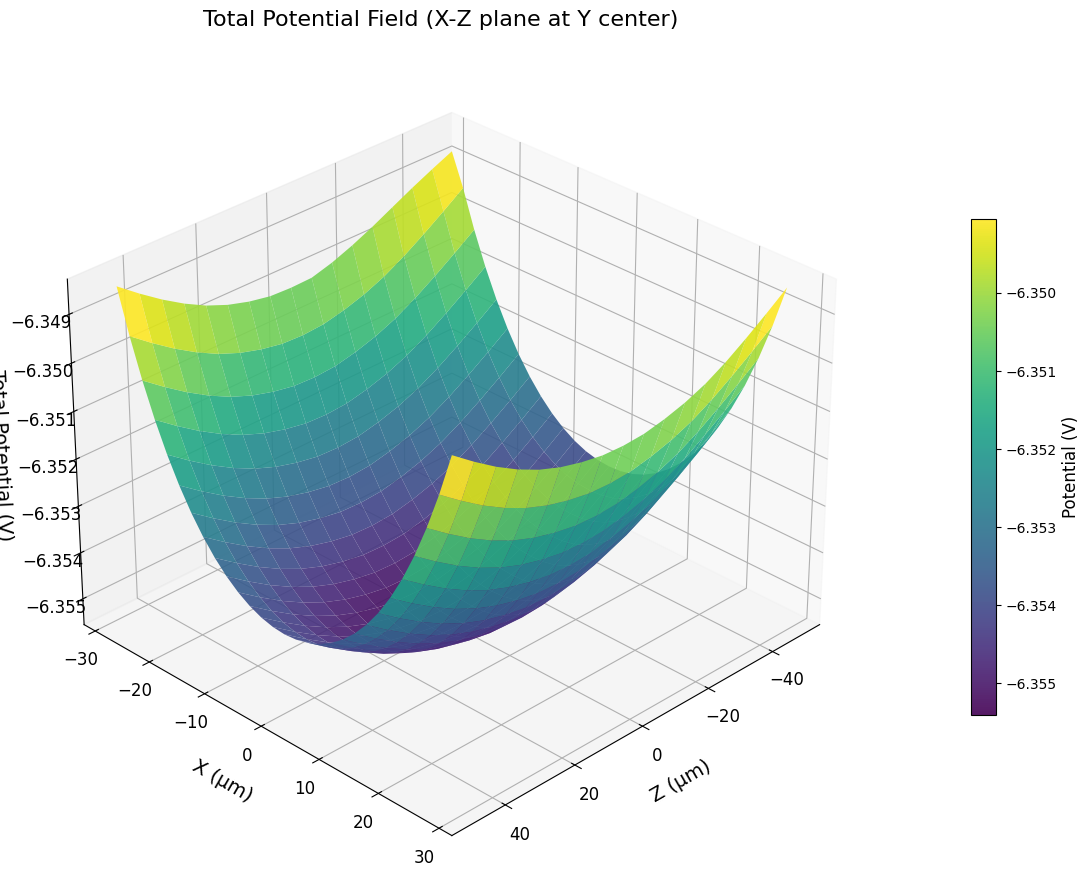


三维势场图信息
X方向范围: [-30, 30] μm
Z方向范围: [-50, 50] μm
Y方向位置: 0.00 μm (中心)
势场范围: [-6.3554, -6.3484] V
数据点数量: X=29, Z=17


In [9]:
# 绘制总势场三维图（z方向±50um，x方向±30um）
# 获取总势场数据和坐标
V_total = result['V_total']
x_um = result['coordinates']['x']
y_um = result['coordinates']['y']
z_um = result['coordinates']['z']

# 设置范围限制
x_range = [-30, 30]  # x方向±30um
z_range = [-50, 50]  # z方向±50um

# 找到y方向的中心索引
y_center_idx = len(y_um) // 2

# 找到x和z方向在指定范围内的索引
x_mask = (x_um >= x_range[0]) & (x_um <= x_range[1])
z_mask = (z_um >= z_range[0]) & (z_um <= z_range[1])

# 提取范围内的数据
x_plot = x_um[x_mask]
z_plot = z_um[z_mask]

# 提取y中心切面的总势场数据（在x-z平面上）
V_total_slice = V_total[:, y_center_idx, :]  # shape: (len(x), len(z))
V_total_plot = V_total_slice[np.ix_(x_mask, z_mask)]  # 提取指定范围

# 创建网格
X, Z = np.meshgrid(z_plot, x_plot)

# 绘制3D表面图
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# 绘制表面
surf = ax.plot_surface(X, Z, V_total_plot, cmap='viridis', 
                       linewidth=0, antialiased=True, alpha=0.9)

# 设置标签和标题
ax.set_xlabel('Z (μm)', fontsize=14, labelpad=10)
ax.set_ylabel('X (μm)', fontsize=14, labelpad=10)
ax.set_zlabel('Total Potential (V)', fontsize=14, labelpad=10)
ax.set_title('Total Potential Field (X-Z plane at Y center)', fontsize=16, pad=20)

# 设置刻度
ax.tick_params(labelsize=12)

# 添加颜色条
cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
cbar.set_label('Potential (V)', fontsize=12)

# 设置视角
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# 输出信息
print("\n" + "="*60)
print("三维势场图信息")
print("="*60)
print(f"X方向范围: [{x_range[0]}, {x_range[1]}] μm")
print(f"Z方向范围: [{z_range[0]}, {z_range[1]}] μm")
print(f"Y方向位置: {y_um[y_center_idx]:.2f} μm (中心)")
print(f"势场范围: [{np.min(V_total_plot):.4f}, {np.max(V_total_plot):.4f}] V")
print(f"数据点数量: X={len(x_plot)}, Z={len(z_plot)}")
print("="*60)